In [1]:
%pylab inline
%config InlineBackend.figure_format ='retina'

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
def latex_on_mac_only():
    import sys
    if sys.executable == '/Users/kwhuang/anaconda3/bin/python':    # on Mac
        from matplotlib import rc
        rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
        rc('text', usetex=True)

In [3]:
latex_on_mac_only()

In [4]:
lw = 3

In [5]:
def calc_Mv_from_gaia(g, bp_rp):
    """ https://arxiv.org/pdf/1804.09368.pdf """
    a0, a1, a2 = 0.0176, 0.00686, 0.1732
    return g + a0 + a1*bp_rp + a2*bp_rp

In [6]:
def m2M(m, d):
    return m - 5.*np.log10(d) + 5.

def Lv2Mv(Lv):
    """ convert Lv to Mv in the unit of L_sun """
    Mv_sun = 4.83
    return Mv_sun - 2.5 * np.log10(Lv)

def Mv2Lv(Mv):
    Mvsun = 4.83
    return  10**(-0.4*(Mv - Mvsun))

In [7]:
betw = lambda x, x1, x2: (x >= x1) & (x < x2)

In [8]:
import imf as iimf

nsample = int(1e7)
mass_sample = iimf.Chabrier().distr.rvs(nsample)

In [9]:
def scipy_inter_iso(mini, mag, mini_sample):
    """ Interpolate the magnitude manually with scipy
    : mini : initial mass from database
    : mag : magnitude from database
    : mini_sample : initial mass samples
    """
    import scipy.interpolate 
    INTERPOLATE = scipy.interpolate.UnivariateSpline(mini, mag, s=0, k=1, ext=1)
    pred_mag = INTERPOLATE(mini_sample)
    return  pred_mag[pred_mag != 0]

In [10]:
import sqlutilpy as sqlutil

sql_str = '''
    select  mini, gmag, g_bpmag, g_rpmag
    from  isochrones.gaia_1804 
    where age=12000000000 and feh=-2.0
    '''

mini, gmag, g_bpmag, g_rpmag = sqlutil.get(sql_str, host='wsdb.hpc1.cs.cmu.edu', user='kuan_wei', password=']VxyR1do')

mini[113] = mini[113] + 1e-10

In [11]:
pred_gmag = scipy_inter_iso(mini, gmag, mass_sample)
pred_g_bpmag = scipy_inter_iso(mini, g_bpmag, mass_sample)
pred_g_rpmag = scipy_inter_iso(mini, g_rpmag, mass_sample)

pred_bp_rp = pred_g_bpmag - pred_g_rpmag
pred_vmag = calc_Mv_from_gaia(pred_gmag, pred_bp_rp)

In [12]:
# bp_rp_scipy = pred_g_bpmag - pred_g_rpmag
# g_scipy = pred_gmag

Text(0, 0.5, 'G')

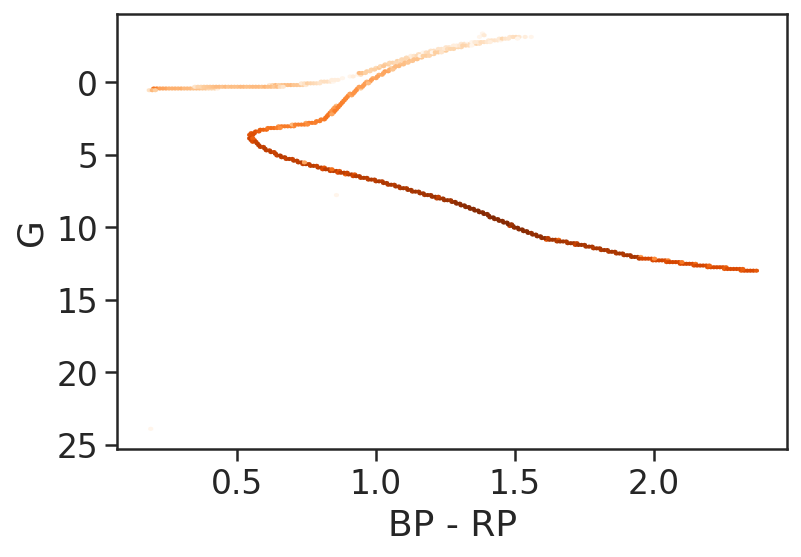

In [13]:
sns.set(style="white", color_codes=True, font_scale=1.5)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.hexbin(pred_bp_rp, pred_gmag, label='iso', mincnt=1, cmap='Oranges', bins='log', gridsize=200)

ax.invert_yaxis()
ax.set_xlabel('BP - RP')
ax.set_ylabel('G')

In [14]:
dmgrid = np.arange(15, 25, 0.1)
nstar_betw_scipy = np.array([betw(pred_gmag + dmgrid[i], 17, 21).sum() for i in range(len(dmgrid))])

Text(0, 0.5, 'Nstars: 17 < G <21')

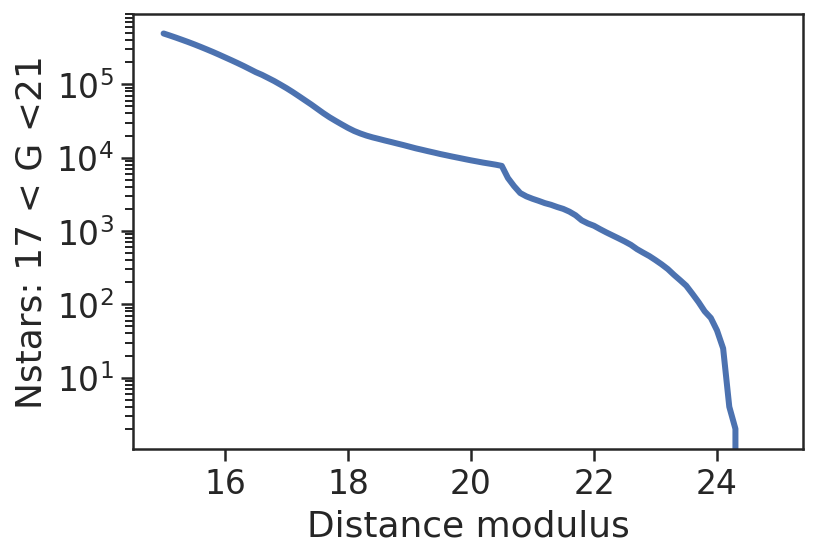

In [15]:
sns.set(style="white", color_codes=True, font_scale=1.5)
sns.set_style("ticks", {"xtick.direction": "out", "ytick.direction": "out"})
fig, ax = plt.subplots()

ax.semilogy(dmgrid, nstar_betw_scipy, lw=lw)

ax.set_xlabel('Distance modulus')
ax.set_ylabel('Nstars: 17 < G <21')

In [16]:
gc_vmag = Lv2Mv(Mv2Lv(pred_vmag).sum())
print(gc_vmag)

-10.822758570423295


In [17]:
def calc_dm(d):    # d in pc
    return 5. * np.log10(d / 10.)

In [18]:
dist_fnx = 147e3
dm_fnx = calc_dm(dist_fnx)
nstar_obs_fnx = betw(pred_gmag + dm_fnx, 17, 21).sum()
print(nstar_obs_fnx)

3141


In [26]:
ngc_tot = 10
nsamples = np.logspace(2., 7., num=ngc_tot)

dict_gc = {}

for i in range(ngc_tot):
    mass_sample = iimf.Chabrier().distr.rvs(int(nsamples[i]))
    
    pred_gmag = scipy_inter_iso(mini, gmag, mass_sample)
    pred_g_bpmag = scipy_inter_iso(mini, g_bpmag, mass_sample)
    pred_g_rpmag = scipy_inter_iso(mini, g_rpmag, mass_sample)
    
    pred_bp_rp = pred_g_bpmag - pred_g_rpmag
    pred_vmag = calc_Mv_from_gaia(pred_gmag, pred_bp_rp)
    gc_vmag = Lv2Mv(Mv2Lv(pred_vmag).sum())
    
    dict_gc[i] = (gc_vmag, pred_gmag)


In [27]:
print(dict_gc)

{0: (2.150749032424518, array([ 8.57418654, 10.44310495,  7.19955558, 11.12004245,  7.57184479,
        7.37365666, 10.33659453, 10.89345499,  8.34086831, 10.28153696,
       10.68133537, 11.56102633,  8.77094438, 10.92618003,  8.63546183,
        4.32848627,  6.03749047,  8.63108728,  7.23179852,  3.6041174 ,
        3.34356706,  9.1640405 , 11.04108415,  9.87040077,  6.82786279,
        8.75577191,  8.28847199,  8.99404847,  6.59507662,  8.00426917,
       11.52021208, 10.21700605,  8.23998526,  8.47044304, 10.53620085,
        4.17418625, 10.62236069,  6.19327305,  7.29394865, 10.83047746,
       11.66844267, 12.81054382,  9.89129115,  4.91186438,  8.9827016 ])), 1: (1.0087904324681372, array([12.69970851,  7.97501425,  9.1846295 ,  8.24715229, 12.72853413,
        9.46854832,  9.46194693,  8.27827618,  9.37594515,  6.70722527,
        9.60525965, 10.42477583,  9.11706408,  8.12798774, 11.2699678 ,
       10.38229955, 11.08995959, 11.93489824,  6.30367151, 11.28962509,
        9.258